# Simulation Methods Project

Adapted from Maciej Workiewicz

Authors:
* Pauline Engel
* Sebastian Erhardt
* Saskia Hasreiter
* Leo Schwarze
* Felix Siegel


In [1]:
import os
from time import time
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools

In [2]:
AMOUNT_OF_ITERATIONS = 1000  # we will generate 1000 NK landscapes to begin with

## Interaction Matrix

In [4]:
def generate_random_interaction_matrix(N: int, K: int):
    '''
    This function takes the number of N elements and K interdependencies
    and creates a random N x N interaction matrix.
    All elements on the diagonal [0,0],[1,1],...[N-1,N-1] will be 1s.
    Based on the K, there will be additional K 1 in each row in addition to the diagonal.
    '''
    Int_matrix_rand = np.zeros((N, N)) # generate a N x N Matrix
    for aa1 in np.arange(N): # iterate over the indexes from 0,1,... to N
        Indexes_1 = list(range(N)) # generate a list from 0,1,... to N
        Indexes_1.remove(aa1)  # remove aa1 index e.g. remove 2 from the list
        np.random.shuffle(Indexes_1) # shuffle the indexes
        Indexes_1.append(aa1) # add the removed index again at the end
        Chosen_ones = Indexes_1[-(K+1):]  # extract the last K indexes in the shuffled 
        for aa2 in Chosen_ones: # iterate over the extracted indexes
            Int_matrix_rand[aa1, aa2] = 1  # set the poistion to 1 in the result matrix
    return(Int_matrix_rand)

## Calculate Coefficient

In [12]:
def calculate_coefficient(position, N:int, C:float):
    # sum of 1s in the position vector
    sum_of_ones = np.sum(position) 
    # get the max amount of the same values
    same_values = max(sum_of_ones, N-sum_of_ones)
    # calculate the coefficient
    coefficient = (1+((same_values/N)-0.5))**(same_values-(N/2))    
    # multiply the coefficient with the fitness factor
    result = coefficient * C    
    return result

In [13]:
calculate_coefficient(np.array([0,1,1,1,0,1]), 5, 0.1)

0.14822280526288795

In [14]:
calculate_coefficient(np.array([1,1,1,1,1,1]), 5, 0.1)

0.6405768283352122

In [15]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 0.1)

0.27556759606310754

## Fitness Calculation

In [18]:
def calculate_fitness_vector(landscape, interaction_matrix, position, power_key, N, C):
    '''
    Takes the landscape, an interaction matrix and a given combination and returns a vector of fitness
    values for the vector of the N decision variables.
    ''' 
    result = np.zeros(N) # initialize the fitness vector with length N and 0
    for y in np.arange(N):
        x = np.sum(position * interaction_matrix[y] * power_key)  
        # calculate the percieved fitness
        percieved_fitness = landscape[x, y] + calculate_coefficient(position, N, C)        
        result[y] = percieved_fitness
    return(result)

## Calc Values for Landscapes

In [30]:
def generate_landscape(N:int, K:int, C:float, power_key):
    """
    Calculates values for all positions on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    """
    # generate a random interaction matrix
    interaction_matrix = generate_random_interaction_matrix(N, K).astype(int)
    # generate a random 2^N x N matrix
    # in every cell there is a random value between 0 and 1
    random_landscape = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    
    # inizialize a result matrix 
    # with the dimensions 2^N and N*2+3
    # the + 3 store the:
    # - the mean of the fitness vector
    # - if the position is a lokal peak
    # - if the position is a global peak
    result = np.zeros((2**N, N*2+3))  # to capture the results
    position_counter = 0  # starting counter for location
    
    # iterate over all possible representations of a list of the lenth of N
    # filled with 0s and 1s
    # starting with [0,0,0,0,..]
    # ending with [1,1,1,1,..]
    # so in the end there are 2^N combinations
    # imagine these combination as the position in the landscape
    for i in range(2**N):
        position = np.array(list(np.binary_repr(i).zfill(N))).astype(int) # taking each position
        
        # now calculate the fitness vector
        fit_1 = calculate_fitness_vector(random_landscape, interaction_matrix, position, power_key, N, C)
        
        result[position_counter, :N] = position  # store the position in the matrix
        result[position_counter, N:2*N] = fit_1
        result[position_counter, 2*N] = np.mean(fit_1)
        position_counter = position_counter + 1
    

    # look for the peaks    
    for c3 in np.arange(2**N):  # now let's see if it is a local peak
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = result[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((result[c3, 2*N] <
                 result[np.sum(new_comb*power_key), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        result[c3, 2*N+1] = loc_p
    
    # store the global peak
    max_ind = np.argmax(result[:, 2*N]) # get the max result from the local peaks
    result[max_ind, 2*N+2] = 1 # set the global peak to 1
    return(result)

## Generate Landscapes

In [43]:
def generate_landscapes(N:int, K:int, C:float, power_key):
    # init empty landscapes tensor
    # Iterations
    # Landscape
    # Results
    landscapes = np.zeros((AMOUNT_OF_ITERATIONS, 2**N, N*2+3))  # we prepare an array to receive the data
    
    # iterate based on AMOUNT_OF_ITERATIONS
    # generate a landscape each time
    for iteration in np.arange(AMOUNT_OF_ITERATIONS):
        landscapes[iteration] = generate_landscape(N, K, C, power_key)
        
    return landscapes

## Statistics

In [51]:
def generate_title(N, K, C, p_jump):
    return f"N = {N}, K = {K}, C = {C}, p_jump = {p_jump}"

In [53]:
def print_statistics(landscapes, N, K, C, p_jump):    
    number_of_peaks = np.zeros(AMOUNT_OF_ITERATIONS)
    max_values = np.zeros(AMOUNT_OF_ITERATIONS)
    min_values = np.zeros(AMOUNT_OF_ITERATIONS)
    
    for i_2 in np.arange(AMOUNT_OF_ITERATIONS):
        number_of_peaks[i_2] = np.sum(landscapes[i_2, :, 2*N+1])
        max_values[i_2] = np.max(landscapes[i_2, :, 2*N])
        min_values[i_2] = np.min(landscapes[i_2, :, 2*N])
    
    # Let's print some summary statistics of our sample of NK landscapes
    print('Summary statistics')
    print(generate_title(N, K, C, p_jump))
    print('average number of peaks: ' + str(np.mean(number_of_peaks)))
    print('maximum number of peaks: ' + str(np.max(number_of_peaks)))
    print('minimum number of peaks: ' + str(np.min(number_of_peaks)))
    print('average maximum value: ' + str(np.mean(max_values)))
    print('average minimum value: ' + str(np.mean(min_values)))
    
    # plot histogram of the number of local peaks in our sample
    plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue') 
    plt.title('Distribution of the number of peaks \n' + generate_title(N, K, C, p_jump), size=12)
    plt.xlabel('number of peaks', size=10)
    plt.ylabel('frequency', size=10)
    plt.show()

## Search

In [54]:
def run_search(landscapes, N: int, K: int, C:float, p_jump:float, power_key):
  
    Output2 = np.zeros((AMOUNT_OF_ITERATIONS, t))
    
    for i1 in np.arange(AMOUNT_OF_ITERATIONS):
        combination = np.random.binomial(1, 0.5, N)  # gen initial combination
        row = np.sum(combination*power_key)  # finding the address in the array
        fitness = landscapes[i1, row, 2*N]  # piggyback on work done previously
        max_fit = np.max(landscapes[i1, :, 2*N])  # we will use it for normalization
        min_fit = np.min(landscapes[i1, :, 2*N])  # ditto
        fitness_norm = (fitness - min_fit)/(max_fit - min_fit)  # normalize 0 to 1
        
        # search
        for t1 in np.arange(t):  # time for local search
            Output2[i1, t1] = fitness_norm
            if np.random.rand() < p_jump:  # check whether we are doing a jump
                new_combination = np.random.binomial(1, 0.5, N)
            else:  # if not, then we simply search locally
                new_combination = combination.copy()
                choice_var = np.random.randint(N)
                new_combination[choice_var] = abs(new_combination[choice_var] - 1)
                
            row = np.sum(new_combination*power_key)
            new_fitness = landscapes[i1, row, 2*N]
            if new_fitness > fitness:  # if we have found a better combination
                combination = new_combination.copy()
                fitness = new_fitness.copy()
                fitness_norm = (fitness - min_fit)/(max_fit - min_fit)
            # otherwise all stays the same as in the previous round
    Fitness2 = np.mean(Output2, axis=0)
    
    # *** 3. PLOT ***************************************************************
    
    # We will do a simple plot of the average fitness value over t periods
    plt.figure(1, facecolor='white', figsize=(8, 6))
    plt.plot(Fitness2, color='green', linewidth=2, label='p_jump='+str(p_jump))
    plt.ylim(0.5, 1)
    plt.legend(loc=4,prop={'size':10})
    plt.title('Results of local search\n' + generate_title(N, K, C, p_jump), size=12)
    plt.xlabel('time periods', size=12)
    plt.ylabel('fitness', size=12)
    plt.show()
    print('Final fitness level for long jumps: ' + str(Fitness2[t-1]))
    
    # END OF LINE

# Experiments

In [61]:
t = 50  # time periods 

In [62]:
def run_experiment(N=5, K=3, C=0.0, p_jump=0):
    print(f"Run experiment with N = {N}, K = {K}, C = {C}, p_jump = {p_jump}")
    print("\n")
    # generate power key based on N
    power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape   
    
    landscapes = generate_landscapes(N, K, C, power_key)
    print_statistics(landscapes, N, K, C, p_jump)
    run_search(landscapes, N, K, C, p_jump, power_key)
    print("\n")
    print("#######################################################")
    print("\n\n\n")

## Run Experiments

In [63]:
Ns = [5]
Ks = [0,4]
Cs = [0,0.1,0.5,1]
p_jumps = [0.0,0.5,1]

Run experiment with N = 5, K = 0, C = 0, p_jump = 0.0


Summary statistics
N = 5, K = 0, C = 0, p_jump = 0.0
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6667705631564897
average minimum value: 0.3315947024923957


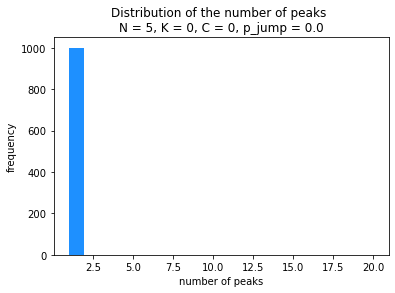

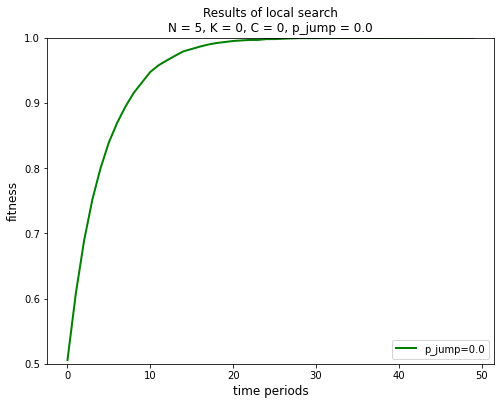

Final fitness level for long jumps: 1.0


#######################################################




Run experiment with N = 5, K = 0, C = 0, p_jump = 0.5


Summary statistics
N = 5, K = 0, C = 0, p_jump = 0.5
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6683080337949813
average minimum value: 0.33579727558914496


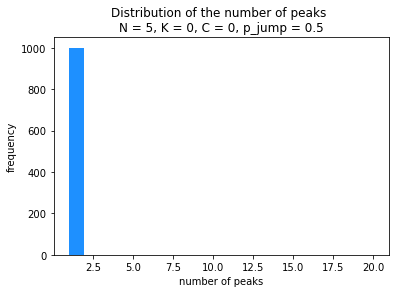

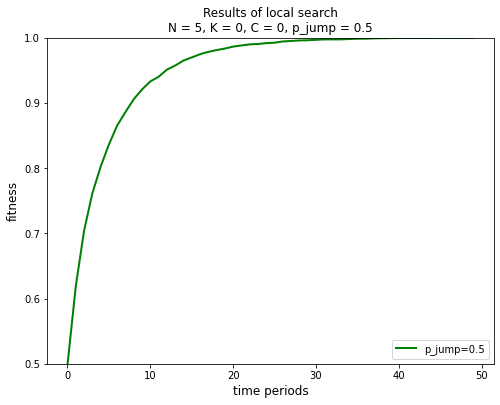

Final fitness level for long jumps: 0.9997275591514521


#######################################################




Run experiment with N = 5, K = 0, C = 0, p_jump = 1


Summary statistics
N = 5, K = 0, C = 0, p_jump = 1
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6662621166617727
average minimum value: 0.3326767883378034


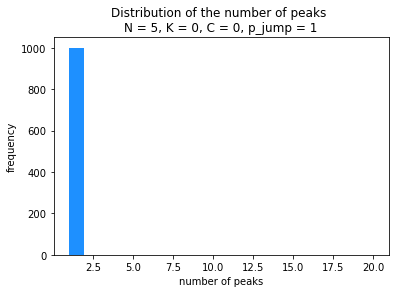

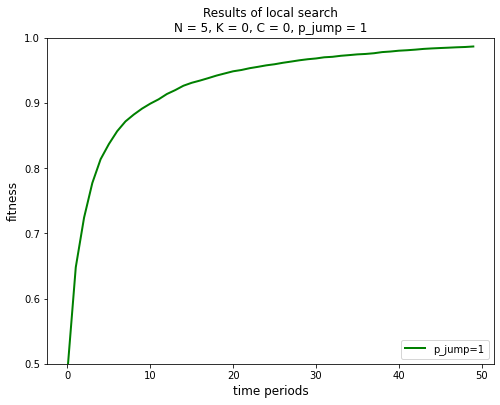

Final fitness level for long jumps: 0.9864389524025333


#######################################################




Run experiment with N = 5, K = 0, C = 0.1, p_jump = 0.0


Summary statistics
N = 5, K = 0, C = 0.1, p_jump = 0.0
average number of peaks: 1.83
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8491380847633455
average minimum value: 0.44516655858589477


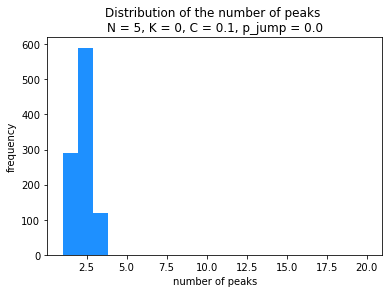

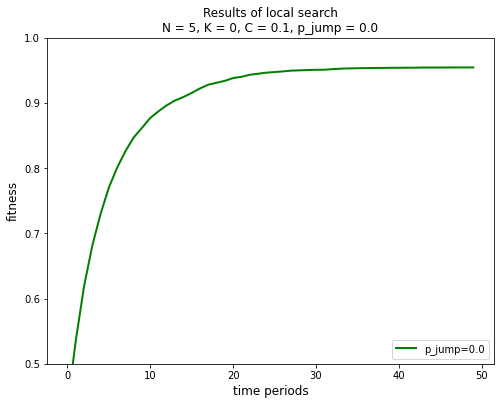

Final fitness level for long jumps: 0.9543081393631543


#######################################################




Run experiment with N = 5, K = 0, C = 0.1, p_jump = 0.5


Summary statistics
N = 5, K = 0, C = 0.1, p_jump = 0.5
average number of peaks: 1.812
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8530837231489266
average minimum value: 0.44917661205956133


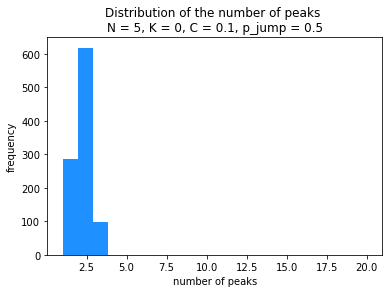

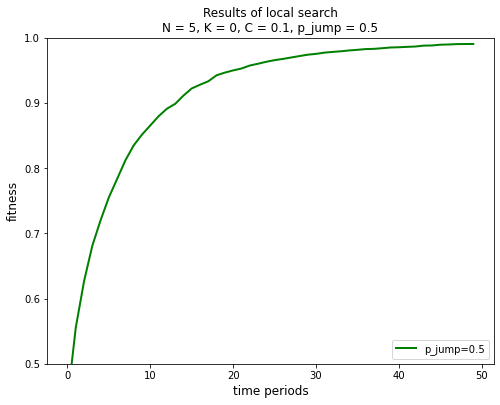

Final fitness level for long jumps: 0.9903071650648008


#######################################################




Run experiment with N = 5, K = 0, C = 0.1, p_jump = 1


Summary statistics
N = 5, K = 0, C = 0.1, p_jump = 1
average number of peaks: 1.78
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8582966967741904
average minimum value: 0.4489653074952125


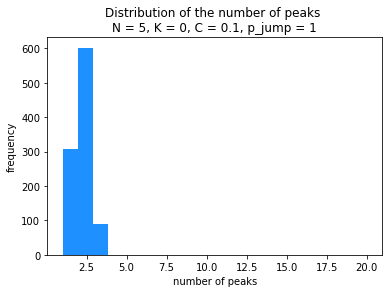

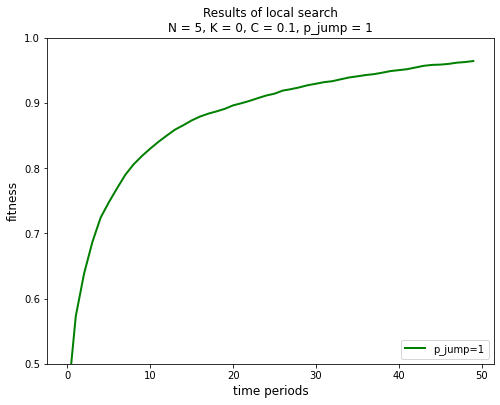

Final fitness level for long jumps: 0.964136079113387


#######################################################




Run experiment with N = 5, K = 0, C = 0.5, p_jump = 0.0


Summary statistics
N = 5, K = 0, C = 0.5, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.947635871943481
average minimum value: 0.863303528411702


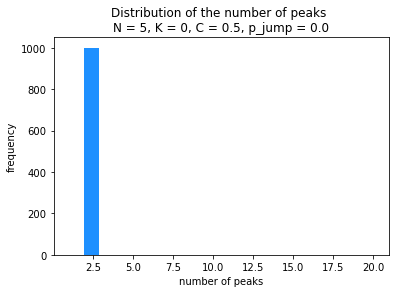

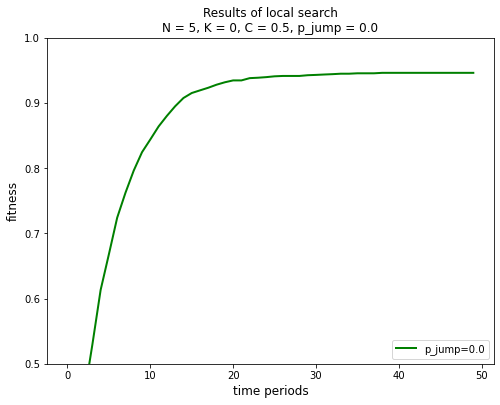

Final fitness level for long jumps: 0.9460424826516498


#######################################################




Run experiment with N = 5, K = 0, C = 0.5, p_jump = 0.5


Summary statistics
N = 5, K = 0, C = 0.5, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.953889400455366
average minimum value: 0.8724121742805542


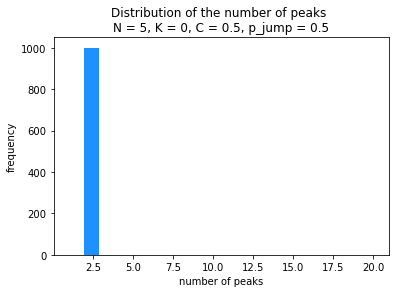

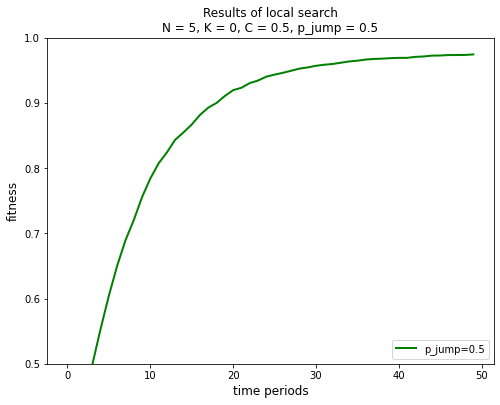

Final fitness level for long jumps: 0.9742631638425497


#######################################################




Run experiment with N = 5, K = 0, C = 0.5, p_jump = 1


Summary statistics
N = 5, K = 0, C = 0.5, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.9476619896156926
average minimum value: 0.8657313792730501


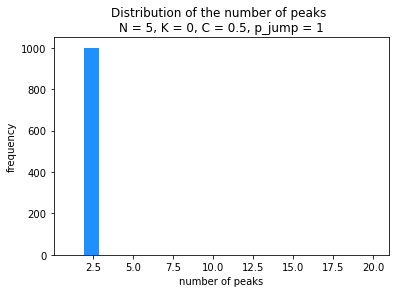

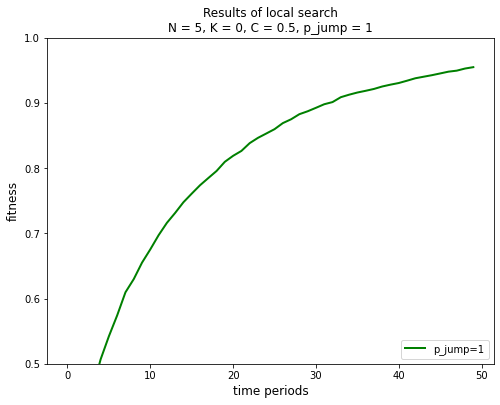

Final fitness level for long jumps: 0.9547550273507198


#######################################################




Run experiment with N = 5, K = 0, C = 1, p_jump = 0.0


Summary statistics
N = 5, K = 0, C = 1, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.333719956265784
average minimum value: 1.4017284130949068


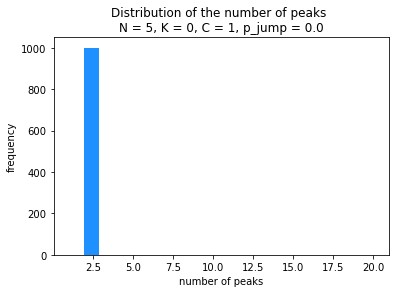

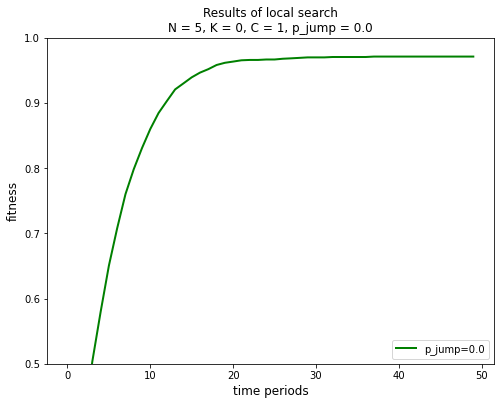

Final fitness level for long jumps: 0.9709770867048487


#######################################################




Run experiment with N = 5, K = 0, C = 1, p_jump = 0.5


Summary statistics
N = 5, K = 0, C = 1, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.3236653014079676
average minimum value: 1.3898845875423735


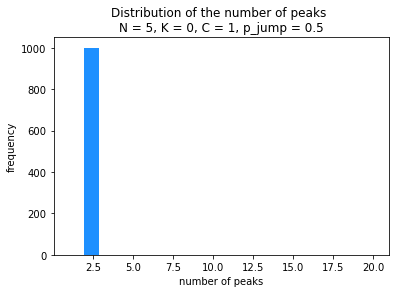

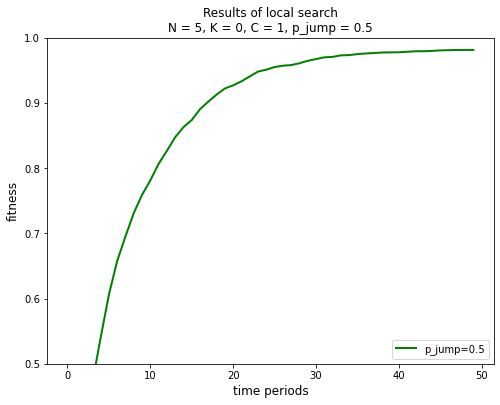

Final fitness level for long jumps: 0.9811626068226726


#######################################################




Run experiment with N = 5, K = 0, C = 1, p_jump = 1


Summary statistics
N = 5, K = 0, C = 1, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.325524325832752
average minimum value: 1.388571456294707


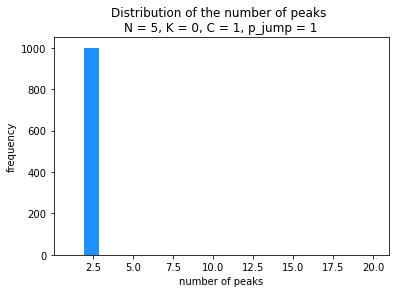

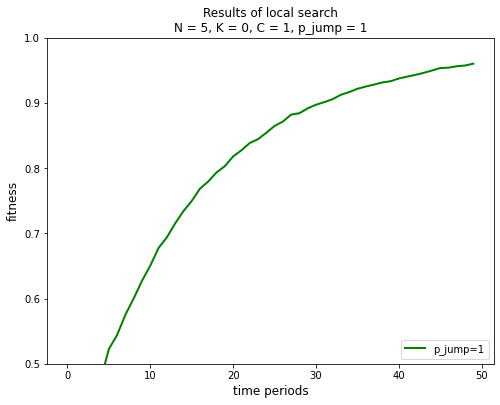

Final fitness level for long jumps: 0.9600732690138295


#######################################################




Run experiment with N = 5, K = 4, C = 0, p_jump = 0.0


Summary statistics
N = 5, K = 4, C = 0, p_jump = 0.0
average number of peaks: 5.285
maximum number of peaks: 10.0
minimum number of peaks: 2.0
average maximum value: 0.7633961835435285
average minimum value: 0.2350832223088666


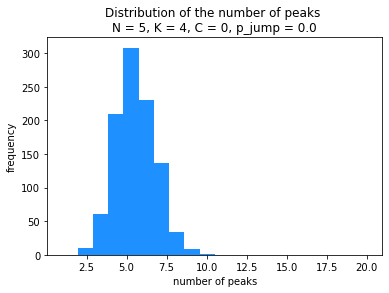

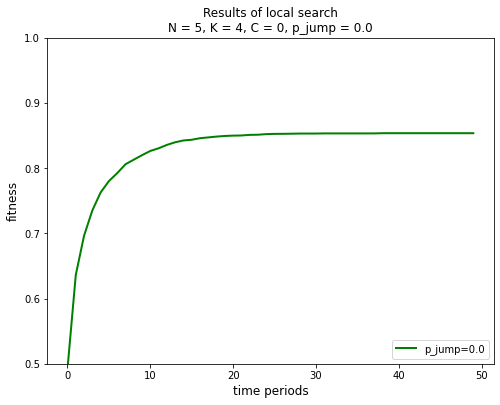

Final fitness level for long jumps: 0.8535084683302097


#######################################################




Run experiment with N = 5, K = 4, C = 0, p_jump = 0.5


Summary statistics
N = 5, K = 4, C = 0, p_jump = 0.5
average number of peaks: 5.33
maximum number of peaks: 10.0
minimum number of peaks: 1.0
average maximum value: 0.7602072187758261
average minimum value: 0.24063970930753886


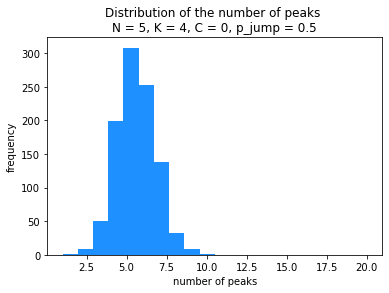

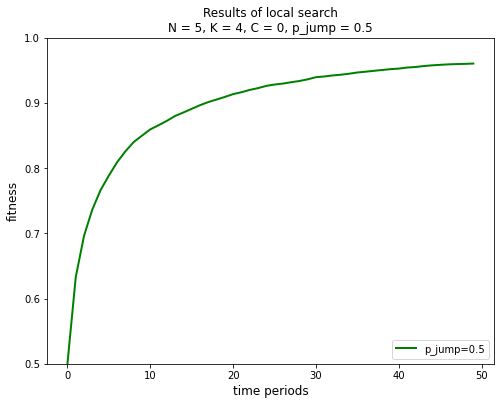

Final fitness level for long jumps: 0.9602793023135251


#######################################################




Run experiment with N = 5, K = 4, C = 0, p_jump = 1


Summary statistics
N = 5, K = 4, C = 0, p_jump = 1
average number of peaks: 5.347
maximum number of peaks: 12.0
minimum number of peaks: 2.0
average maximum value: 0.7635770672355355
average minimum value: 0.24237738690929042


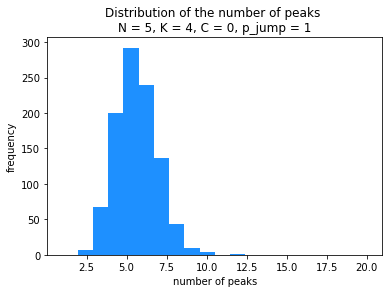

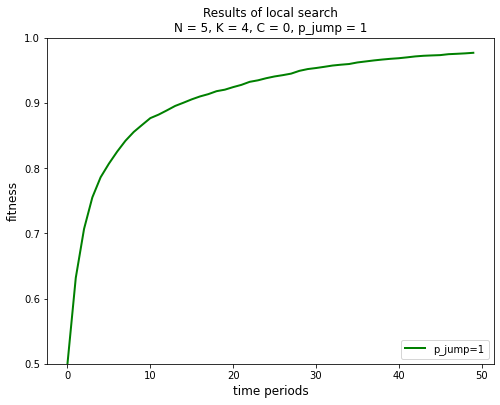

Final fitness level for long jumps: 0.9767634229501101


#######################################################




Run experiment with N = 5, K = 4, C = 0.1, p_jump = 0.0


Summary statistics
N = 5, K = 4, C = 0.1, p_jump = 0.0
average number of peaks: 5.058
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average maximum value: 0.9125255985991646
average minimum value: 0.3550279051204359


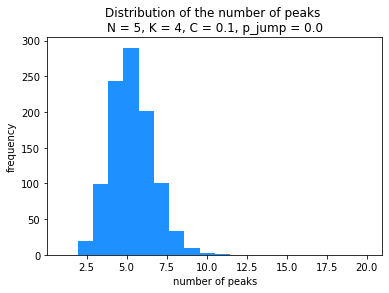

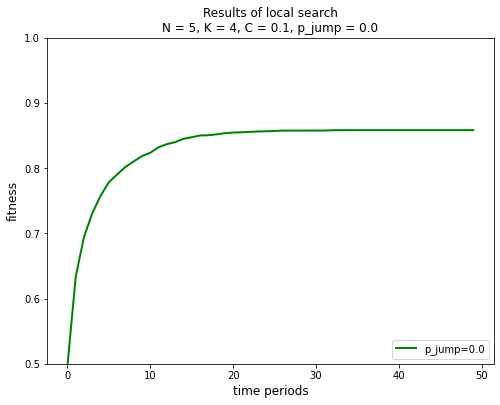

Final fitness level for long jumps: 0.8582408072664796


#######################################################




Run experiment with N = 5, K = 4, C = 0.1, p_jump = 0.5


Summary statistics
N = 5, K = 4, C = 0.1, p_jump = 0.5
average number of peaks: 5.085
maximum number of peaks: 10.0
minimum number of peaks: 2.0
average maximum value: 0.9160356256413855
average minimum value: 0.3551014257232995


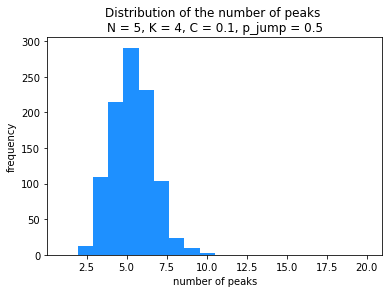

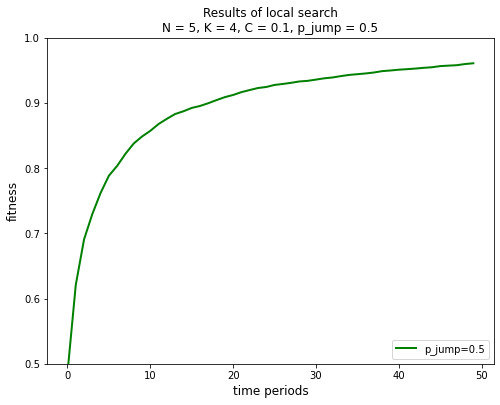

Final fitness level for long jumps: 0.9607235810222917


#######################################################




Run experiment with N = 5, K = 4, C = 0.1, p_jump = 1


Summary statistics
N = 5, K = 4, C = 0.1, p_jump = 1
average number of peaks: 5.02
maximum number of peaks: 12.0
minimum number of peaks: 2.0
average maximum value: 0.9165294463147072
average minimum value: 0.3569786082423456


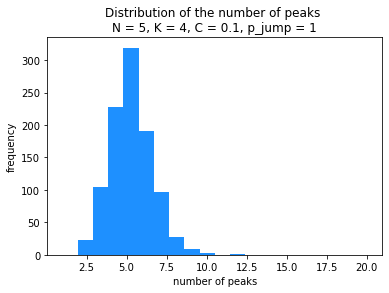

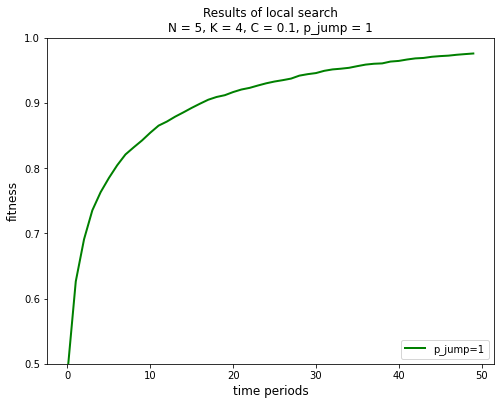

Final fitness level for long jumps: 0.9756979888036437


#######################################################




Run experiment with N = 5, K = 4, C = 0.5, p_jump = 0.0


Summary statistics
N = 5, K = 4, C = 0.5, p_jump = 0.0
average number of peaks: 2.635
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.9493092797158411
average minimum value: 0.7857847442987361


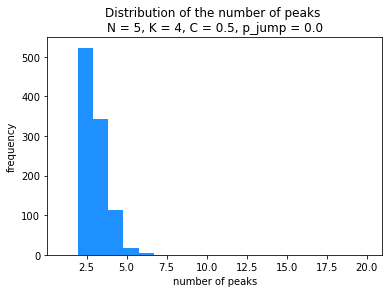

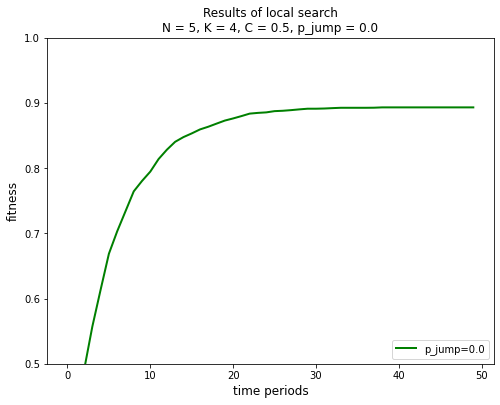

Final fitness level for long jumps: 0.8930934068070532


#######################################################




Run experiment with N = 5, K = 4, C = 0.5, p_jump = 0.5


Summary statistics
N = 5, K = 4, C = 0.5, p_jump = 0.5
average number of peaks: 2.593
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.9513431312593603
average minimum value: 0.7879884629410677


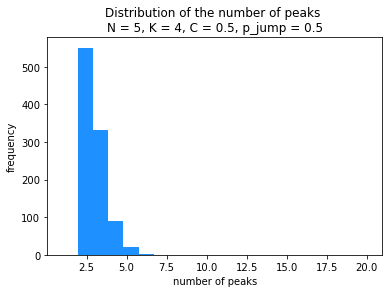

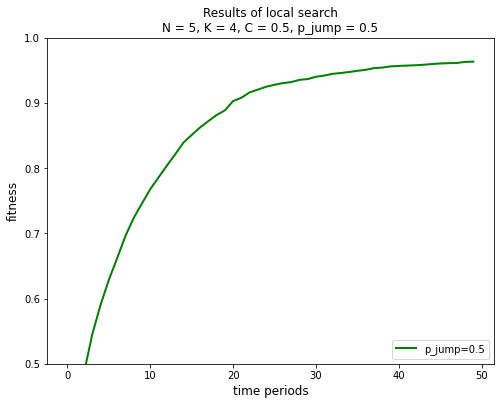

Final fitness level for long jumps: 0.9631850709324122


#######################################################




Run experiment with N = 5, K = 4, C = 0.5, p_jump = 1


Summary statistics
N = 5, K = 4, C = 0.5, p_jump = 1
average number of peaks: 2.65
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.9502305543040692
average minimum value: 0.7876638003611321


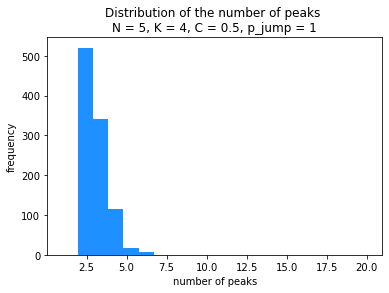

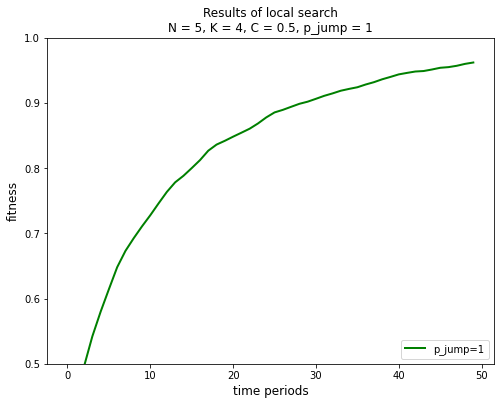

Final fitness level for long jumps: 0.9618830171320787


#######################################################




Run experiment with N = 5, K = 4, C = 1, p_jump = 0.0


Summary statistics
N = 5, K = 4, C = 1, p_jump = 0.0
average number of peaks: 2.018
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.3266668340648384
average minimum value: 1.3091687389244968


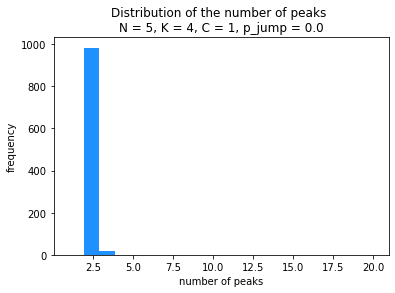

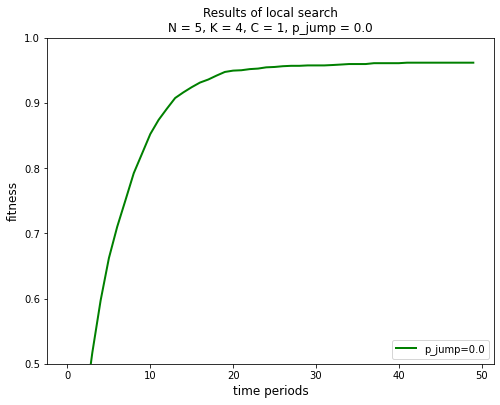

Final fitness level for long jumps: 0.9616088684891273


#######################################################




Run experiment with N = 5, K = 4, C = 1, p_jump = 0.5


Summary statistics
N = 5, K = 4, C = 1, p_jump = 0.5
average number of peaks: 2.017
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.3301464460655557
average minimum value: 1.3098125546467358


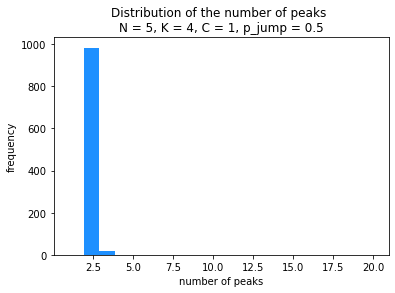

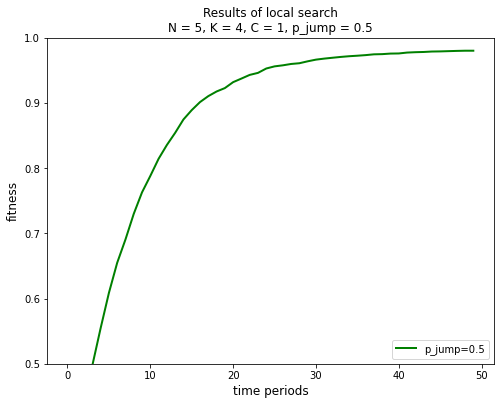

Final fitness level for long jumps: 0.9799564852806377


#######################################################




Run experiment with N = 5, K = 4, C = 1, p_jump = 1


Summary statistics
N = 5, K = 4, C = 1, p_jump = 1
average number of peaks: 2.013
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.3297396381910014
average minimum value: 1.310012212658458


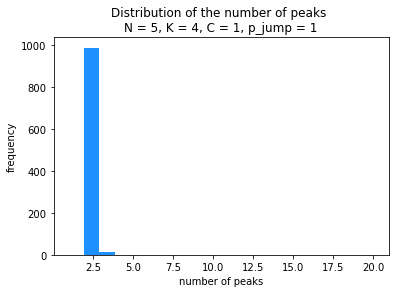

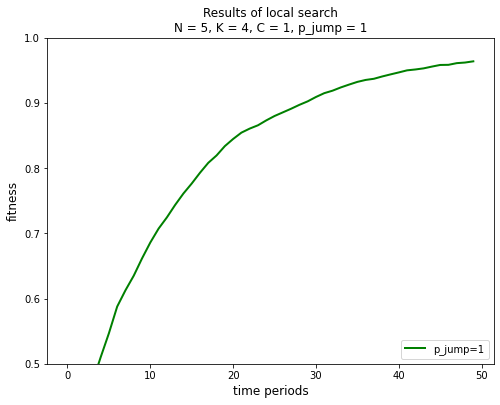

Final fitness level for long jumps: 0.9636890519845537


#######################################################






In [65]:
for N in Ns:
    for K in Ks:
        for C in Cs:
            for p_jump in p_jumps:
                run_experiment(N=N, K=K, C=C, p_jump=p_jump)

In [66]:
print("Done")

Done
